## Introduction example
Expressing the dynamics of a ship as an Ordinary Differential Equation (ODE) is a well established technique. The ODE can be solved as an initial value problem with integration of accelerations and velocities to obtain a ship's trajectory. This is commonly known as a simulation. The workflow of a simulation is to first establish a force model that can estimate the hydrodynamic forces as function of the current state. Accelerations can then be calculated from these forces together with the mass. The velocities and positions can then be determined with time integration of the acceleration.

Let's exemplify this with a simple problem, simulated a ball being dropped in air.
The forces acting on this ball will be the drag from the air, which is modelled as: $C_d \cdot \dot{x}^2$ and the gravity, which is modelled as $g \cdot m$:

In [18]:
# %load imports.py
## Local packages:

%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False  ## (To fix autocomplete)

## External packages:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)

import numpy as np
import os
import matplotlib.pyplot as plt
#if os.name == 'nt':
#    plt.style.use('presentation.mplstyle')  # Windows

import plotly.express as px 
import plotly.graph_objects as go

import seaborn as sns
import sympy as sp
from sympy.physics.mechanics import (dynamicsymbols, ReferenceFrame,
                                      Particle, Point)
from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex, Markdown
from src.substitute_dynamic_symbols import run, lambdify

import pyro

import sklearn
import pykalman
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm

from scipy.integrate import solve_ivp

## Local packages:
from src.data import mdl

from src.symbols import *
from src.parameters import *
import src.symbols as symbols
from src import prime_system
from src.models import regression
from src.visualization.regression import show_pred
from src.visualization.plot import track_plot
from src.equation import Equation

## Load models:
# (Uncomment these for faster loading):
import src.models.vmm_abkowitz  as vmm_abkowitz 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
x = dynamicsymbols('x')
m,F,C_d,g = sp.symbols('m F C_d g')

eq_kinetics = sp.Eq(F, -m*g + C_d*x.diff()**2)
Math(vlatex(eq_kinetics))

<IPython.core.display.Math object>

The kinematics connecting the forces to motion can be described with Newtons 2nd law:

In [7]:
eq_kinematics = sp.Eq(F, m*x.diff().diff())
Math(vlatex(eq_kinematics))

<IPython.core.display.Math object>

The acceleration can then be calculated using these two equations:

In [8]:
eqs=[eq_kinetics,eq_kinematics]
solution = sp.solve(eqs, x.diff().diff(), m, F, dict=True)[0]
eq_acc = sp.Eq(x.diff().diff(),solution[x.diff().diff()])
Math(vlatex(eq_acc))

<IPython.core.display.Math object>

This equation can be used to simulate the motion of the ball, by doing a time step integration of this initial value problem.

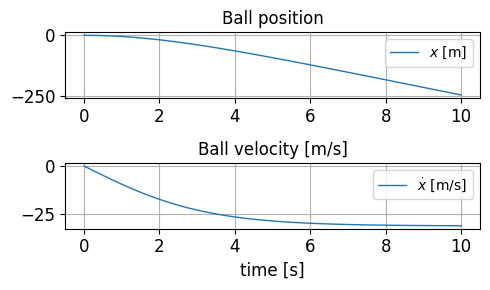

In [16]:
from scipy.integrate import solve_ivp

acceleration_lambda = lambdify(eq_acc.rhs)

inputs={
'C_d' : 0.01,
'g' : 9.81,
'm' : 1,
}

def step(t,states, inputs):

    x1d = states[1]
    x2d = acceleration_lambda(**inputs, x1d=x1d)

    dstates = [x1d, x2d]
    return dstates

t_ = np.linspace(0,10,100)
y0 = [
    0,0
]
solution = solve_ivp(fun=step, y0=y0, t_span=[t_[0],t_[-1]], t_eval=t_, args=(inputs,))

df_result = pd.DataFrame(solution.y.T, index=solution.t, columns=['x','x1d'])

fig,axes=plt.subplots(nrows=2)
ax=axes[0]
df_result.plot(y='x', label='$x$ [m]', ax=ax)

ax.set_title('Ball position')

ax=axes[1]
df_result.plot(y='x1d', label='$\dot{x}$ [m/s]', ax=axes[1])
ax.set_title('Ball velocity [m/s]')
ax.set_xlabel('time [s]')

for ax in axes:
    ax.grid(True)
plt.tight_layout()



This toy example is very simple, but is showing the basic idea behind time simulation of dynamic systems, which is often used to simualte the ship dynamics. The following physical parameters were used in the simulation above:

In [25]:
for coeff in [C_d,g,m]:
    display(sp.Eq(coeff,inputs[str(coeff)]))

Eq(C_d, 0.01)

Eq(g, 9.81)

Eq(m, 1)

## Reversing the problem

This research is however about [Inverse dynamics](https://en.wikipedia.org/wiki/Inverse_dynamics), which is reversing the problem above. Instead of estimating a ships trajectory with a force model, we want to identify this force model, by using a measured ship trajectory. This is very useful when you want to fit a mathematical model to the measured ship motion, either obtained from ship model test or the real ship in full scale operation. The latter is something that today is becoming more and more relevant as more and more operational data is measure and recorded onboard the ships.

### Example
Let's reverse the simple ball drop example above by trying to identify the drag coefficient $C_d$ and graviational constant $g$ based on a measured motion of the ball. We will pretend that the simulated motion above is a measurement.

The equation for the forces acting on the ball can be expressed as s regression problem:

$ y = X \cdot \beta + \epsilon $

Where $X$ is a matrix with features and $\beta$ is a a vector with the parameters that should be regressed. $\epsilon$ is the prediction error. For the current problem the force equation is rewritten as a regression problem below:


In [68]:
diff_eq = regression.DiffEqToMatrix(ode=eq_kinetics, label=F, base_features=[x])
Math(vlatex(diff_eq.acceleration_equation))

<IPython.core.display.Math object>

In [69]:
Math(vlatex(diff_eq.eq_X))

<IPython.core.display.Math object>

In [70]:
Math(vlatex(diff_eq.eq_beta))

<IPython.core.display.Math object>

In [71]:
Math(vlatex(diff_eq.eq_y))

<IPython.core.display.Math object>

In [60]:
kinetics_lambda = lambdify(eq_kinetics.rhs)
df_result['F'] = run(function=kinetics_lambda, inputs=inputs, **df_result)

And this regression problem can be solved using Ordinary Least Square (OLS) regression:

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      F   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.110e+32
Date:                Mon, 23 Aug 2021   Prob (F-statistic):               0.00
Time:                        10:23:41   Log-Likelihood:                 3250.2
No. Observations:                 100   AIC:                            -6496.
Df Residuals:                      98   BIC:                            -6491.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
g*m           -9.8100   4.22e-16  -2.32e+16      0.000      -9.810      -9.810
Cd             0.0100   5.67e-19   1.76e+16      0.000       0.010       0.010
==============================================================================
Omnibus:                      146.102   Durbin-Watson:                   0.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3858.285
Skew:                          -5.510   Prob(JB):                         0.00
Kurtosis:                      31.364   Cond. No.                     1.68e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

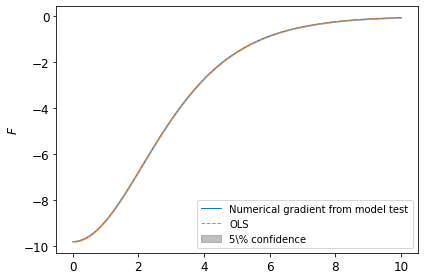

In [72]:
X = diff_eq.calculate_features(data=df_result)
y = diff_eq.calculate_label(y=df_result['F'])

model = sm.OLS(y,X)
results = model.fit()

show_pred(X=X,y=y,results=results, label=r'$F$')

Indentifying the parameters of a mathematical model expressing the dynamics of a system as simple as a droped ball is fairly easy as seen in the examples above. The following research in this book will focus on solving the same problem but for a more complex system as a ship based on data with much more noise than in the perfect data from the simulation example above. 

## So why is it convenient to have a mathematical model of your ship? 